In [3]:
# general imports
import sys
import os.path
import warnings
import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.datasets as datasets

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

sns.set()
warnings.filterwarnings("ignore")
# sys.stdout = open("deep_conv_rf_logs.txt", "w+")

In [16]:
class ConvRF(object):
    def __init__(self, kernel_size=5, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride
        self.kernel_forest = None

    def _convolve_chop(self, images, labels=None, flatten=False):

        batch_size, in_dim, _, num_channels = images.shape

        out_dim = int((in_dim - self.kernel_size) / self.stride) + 1  # calculate output dimensions

        # create matrix to hold the chopped images
        out_images = np.zeros((batch_size, out_dim, out_dim,
                               self.kernel_size, self.kernel_size, num_channels))
        out_labels = None

        curr_y = out_y = 0
        # move kernel vertically across the image
        while curr_y + self.kernel_size <= in_dim:
            curr_x = out_x = 0
            # move kernel horizontally across the image
            while curr_x + self.kernel_size <= in_dim:
                # chop images
                out_images[:, out_x, out_y] = images[:, curr_x:curr_x +
                                                     self.kernel_size, curr_y:curr_y+self.kernel_size, :]
                curr_x += self.stride
                out_x += 1
            curr_y += self.stride
            out_y += 1

        if flatten:
            out_images = out_images.reshape(batch_size, out_dim, out_dim, -1)

        if labels is not None:
            out_labels = np.zeros((batch_size, out_dim, out_dim))
            out_labels[:, ] = labels.reshape(-1, 1, 1)

        return out_images, out_labels

    def convolve_fit(self, images, labels):
        sub_images, sub_labels = self._convolve_chop(images, labels=labels, flatten=True)

        batch_size, out_dim, _, _ = sub_images.shape

        all_sub_images = sub_images.reshape(batch_size*out_dim*out_dim, -1)
        all_sub_labels = sub_labels.reshape(batch_size*out_dim*out_dim, -1)

        self.kernel_forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
        self.kernel_forest.fit(all_sub_images, all_sub_labels)

        convolved_image = np.zeros((images.shape[0], out_dim, out_dim, 1))
        for i in range(out_dim):
            for j in range(out_dim):
                convolved_image[:, i, j] = self.kernel_forest.predict_proba(
                    sub_images[:, i, j])[..., 1][..., np.newaxis]
        return convolved_image

    def convolve_predict(self, images):
        if not self.kernel_forest:
            raise Exception("Should fit training data before predicting")

        sub_images, _ = self._convolve_chop(images, flatten=True)

        batch_size, out_dim, _, _ = sub_images.shape

        kernel_predictions = np.zeros((images.shape[0], out_dim, out_dim, 1))

        for i in range(out_dim):
            for j in range(out_dim):
                kernel_predictions[:, i, j] = self.kernel_forest.predict_proba(
                    sub_images[:, i, j])[..., 1][..., np.newaxis]
        return kernel_predictions

In [9]:
###########################################################################################################
# Data Preparation
###########################################################################################################

cifar_data_path = "../../../data"

def normalize(x):
    scale = np.mean(np.arange(0, 256))
    return (x - scale) / float(scale)


# train data
cifar_trainset = datasets.CIFAR10(root=cifar_data_path, train=True, download=True, transform=None)
cifar_train_images = normalize(cifar_trainset.train_data)
cifar_train_labels = np.array(cifar_trainset.train_labels)

# test data
cifar_testset = datasets.CIFAR10(root=cifar_data_path, train=False, download=True, transform=None)
cifar_test_images = normalize(cifar_testset.test_data)
cifar_test_labels = np.array(cifar_testset.test_labels)

Files already downloaded and verified
Files already downloaded and verified


Label: 0


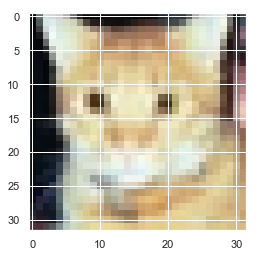

Label: 1


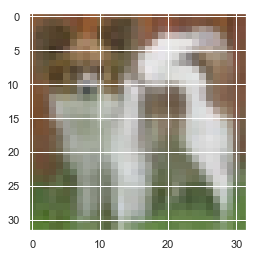

In [14]:
# 3 (cat) vs 5 (dog) classification

def denormalize(y):
    scale = np.mean(np.arange(0, 256))
    return ((y * scale) + scale).astype(np.int)

# get only train images and labels for two classes: 3 and 5
cifar_train_images_3_5 = np.concatenate([cifar_train_images[cifar_train_labels==3], cifar_train_images[cifar_train_labels==5]])
cifar_train_labels_3_5 = np.concatenate([np.repeat(0, np.sum(cifar_train_labels==3)), np.repeat(1, np.sum(cifar_train_labels==5))])

# visualize data and labels

# 3 (label 0) - cat
index = 2500
print("Label:", cifar_train_labels_3_5[index])
plt.imshow(denormalize(cifar_train_images_3_5[index]))
plt.show()

# 5 (label 1) - dog
index = 7500
print("Label:", cifar_train_labels_3_5[index])
plt.imshow(denormalize(cifar_train_images_3_5[index]))
plt.show()

In [70]:
class1 = 3
class2 = 5
fraction_of_train_samples = 0.1

num_train_samples_class_1 = int(np.sum(cifar_train_labels == class1) * fraction_of_train_samples)
num_train_samples_class_2 = int(np.sum(cifar_train_labels == class2) * fraction_of_train_samples)

# get only train images and labels for class 1 and class 2
train_images = np.concatenate([cifar_train_images[cifar_train_labels == class1][:num_train_samples_class_1],
                               cifar_train_images[cifar_train_labels == class2][:num_train_samples_class_2]])
train_labels = np.concatenate(
    [np.repeat(0, num_train_samples_class_1), np.repeat(1, num_train_samples_class_2)])

In [71]:
# Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=10, stride=2)
conv1_map = conv1.convolve_fit(train_images, train_labels)

In [72]:
# conv1_map = conv1.convolve_predict(train_images)

In [234]:
def viz_map(index, conv_map):
    image = denormalize(train_images[index])
    conv_map = np.squeeze(conv_map[index])
    
    fig=plt.figure(figsize=(10,8))
    cmap_choice = 'Reds'

    fig.add_subplot(1, 2, 1)
    plt.imshow(image)
    
    fig.add_subplot(1, 2, 2)
    heatmap = plt.imshow(conv_map, cmap=cmap_choice)

    cbar = plt.colorbar(heatmap, fraction=0.046, pad=0.04)
    ticks = [round(t, 2) for t in cbar.get_ticks()]
    top_tick = " (cat)" if ticks[-1] <= 0.5 else " (dog)"
    bottom_tick = " (cat)" if ticks[0] <= 0.5 else " (dog)"
    ticks = [str(t) for t in ticks]
    cbar.ax.set_yticklabels([ticks[0]+bottom_tick] + ticks[1:-1] + [ticks[-1]+top_tick])
    
    plt.show()

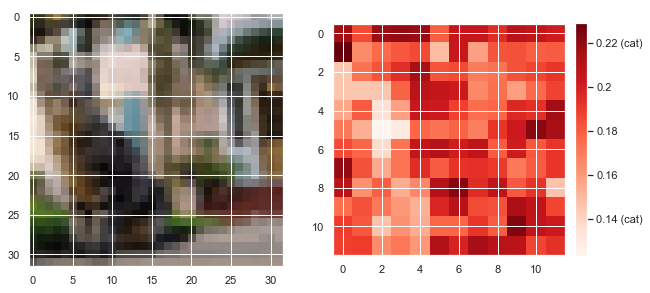

In [211]:
viz_map(100, conv1_map)

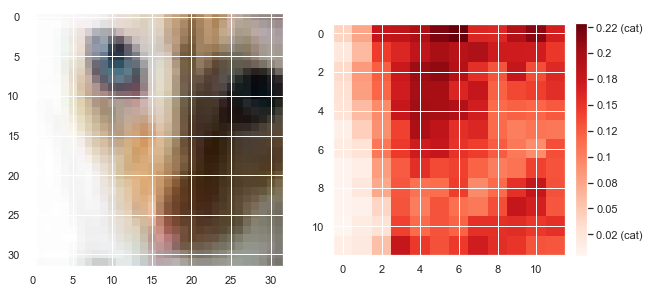

In [231]:
viz_map(220, conv1_map)

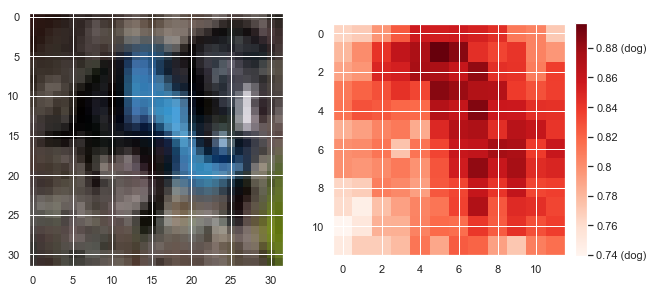

In [213]:
viz_map(500, conv1_map)

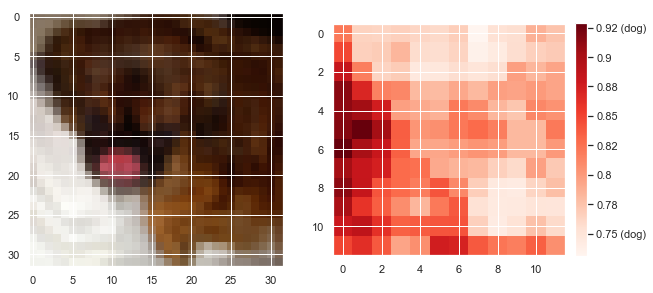

In [228]:
viz_map(999, conv1_map)

In [259]:
# ConvRF (layer 2)
conv2 = ConvRF(kernel_size=7, stride=1)
conv2_map = conv2.convolve_fit(normalize(conv1_map), train_labels)

In [260]:
# a, b = conv2._convolve_chop(normalize(conv1_map), train_labels)
# conv2_map[100]

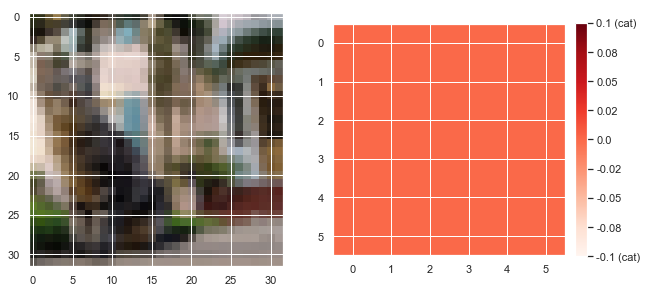

In [257]:
viz_map(100, conv2_map)

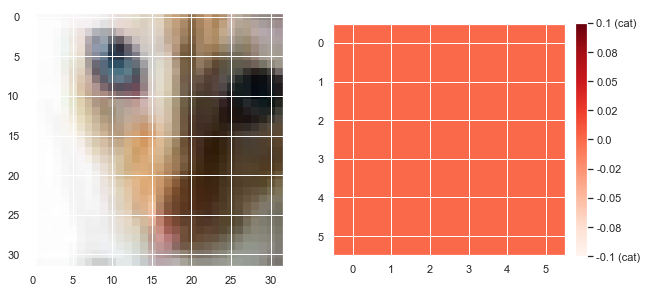

In [237]:
viz_map(220, conv2_map)

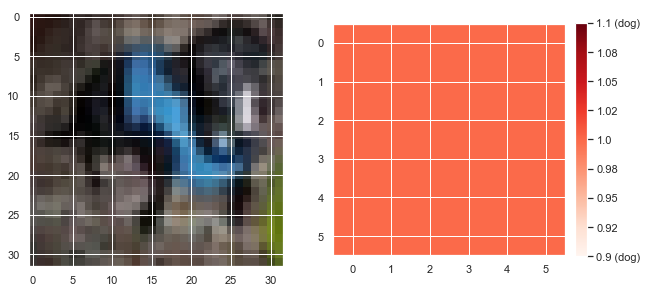

In [239]:
viz_map(500, conv2_map)

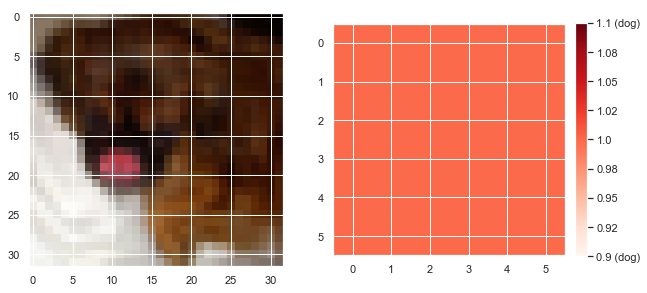

In [238]:
viz_map(999, conv2_map)